# Tarea 2: Machine Learning Avanzado
------


**Universidad San Sebastián**<br>
**Magíster en Data Science**<br>
**Machine Learning Avanzado**

-----

Integrantes:
- Cayunao, Gonzalo
- Gómez, Harold

-----

## Parte 1: Clasificador de Spam

### Código para seleccionar cuál método se usará en el clasificador de spam

In [3]:
import tarfile
import pathlib
import urllib

#Función para descargar los emails que se usarán como dataset de entrenamiento
def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = pathlib.Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

ham_dir, spam_dir = fetch_spam_data()

#A continuación cargamos todos los emails
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

#Usando el módulo de correos electrónicos de Python, para analizarlos (maneja encabezados, codificación, etc)
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

#Imprimimos un ejemplo de ham
print(ham_emails[1].get_content().strip())

#Imprimimos un ejemplo de Spam
print(spam_emails[6].get_content().strip())

#Algunos correos electrónicos son en realidad de varias partes, con imágenes y archivos adjuntos. La siguiente función analiza los distintos tipos de estructuras que tenemos.
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email) for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures
structures_counter(ham_emails).most_common()
structures_counter(spam_emails).most_common()

#Ahora echemos un vistazo al encabezado del correo electrónico.
for header, value in spam_emails[0].items():
    print(header, ":", value)
spam_emails[0]["Subject"]

#Dividimos en un conjunto de entrenamiento y prueba.
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
#La siguiente función deja el texto sin formato HTML
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

#Veamos si funciona, este es un spam HTML
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

#Este es su resultado en texto plano
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")

#La siguiente función toma un correo electrónico como entrada y devuelve el contenido en texto sea cual sea el formato.
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # en caso de encontrar problemas de codificación.
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)
print(email_to_text(sample_html_spam)[:100], "...")

#Ahora agregamos las herramientas de lenguaje natural (NLTK)
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

#Esta librería extrae el contenido de una url.
# %pip install -q -U urlextract
import urlextract

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)
    
#Probemos este transformados en algunos correos electrónicos
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors
X_few_vectors.toarray()
vocab_transformer.vocabulary_
#Transformemos todo el conjunto de datos con las funciones previamente creadas
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/
Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are loo

In [4]:
import joblib
from sklearn.linear_model import LogisticRegression

# Assumiendo que "preprocess_pipeline" y los datos "X_train" e "y_train" están cargados correctamente
# Preprocesar los datos
X_train_transformed = preprocess_pipeline.fit_transform(X_train)

# Entrenar el modelo de nuevo
log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

# Calcular el mejor umbral nuevamente
from sklearn.metrics import precision_recall_curve

X_test_transformed = preprocess_pipeline.transform(X_test)
y_scores = log_clf.predict_proba(X_test_transformed)[:, 1]

# Calcular las curvas de precisión-recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
target_recall = 85.0 / 100  # Objetivo 85%
closest_index = np.argmin(np.abs(recalls - target_recall))
optimal_threshold = thresholds[closest_index]

# Guardar el modelo y el mejor umbral juntos
joblib.dump((log_clf, optimal_threshold), 'modelo_log_class_spam_with_best_threshold.joblib')
joblib.dump(log_clf, 'modelo_log_class_spam.joblib')

['modelo_log_class_spam.joblib']

In [7]:
import joblib

def cargar_modelo(campaña_activa):
    """
    Carga el modelo adecuado según si la campaña está activa o no.

    Parameters:
    campaña_activa (bool): True si la campaña está activa, False si no lo está.

    Returns:
    model: El modelo de clasificación de spam cargado.
    threshold: El umbral de predicción si se está usando el modelo con el mejor umbral, None en caso contrario.
    """
    if campaña_activa:
        # Cargar el modelo diseñado para cuando la campaña está activa
        print("Cargando el modelo para campaña activa...")
        model, threshold = joblib.load('modelo_log_class_spam_with_best_threshold.joblib')
    else:
        # Cargar el modelo predeterminado
        print("Cargando el modelo predeterminado...")
        model = joblib.load('modelo_log_class_spam.joblib')
        threshold = None
    return model, threshold

# Ejemplo de uso
campaña_activa = True  # Cambia esta variable según sea necesario
model, threshold = cargar_modelo(campaña_activa)

if threshold is not None:
    print(f"Umbral del modelo cargado: {threshold}")
else:
    print("Modelo cargado sin umbral específico.")

Cargando el modelo para campaña activa...
Umbral del modelo cargado: 0.9851904642168469


### Documentar  las  diferencias  entre  el  clasificador  actual  que  tienen  en  producción  y  el clasificador  menos  sensible:  para  ello  se  solicita  como  mínimo  entregar  un  cuadro  de diferencias  que  muestre  el  modelo  usado  (si  fue  regresión  logística  también  u  otro),  la precisión, la sensibilidad y F1, como así también la traza de ambas curvas ROC/AUC para certificar que se cumplió con lo solicitado.

Cuadro Comparativo de Métricas

| Métrica            | Clasificador en Producción       | Clasificador Menos Sensible      |
|--------------------|----------------------------------|----------------------------------|
| **Modelo Usado**   | Regresión Logística              | Regresión Logística              |
| **Precisión**      | 96.88%                           | 100.00%                          |
| **Sensibilidad**   | 97.89%                           | 85.26%                           |
| **F1 Score**       | 97.38%                           | 92.05%                           |
| **AUC**            | 98.91%                           | 98.91%                           |

## Análisis de las Diferencias

- **Modelo Usado**: Ambos modelos utilizan regresión logística.
- **Precisión**:
  - Clasificador en Producción: 96.88%
  - Clasificador Menos Sensible: 100.00%
  - **Análisis**: La precisión aumentó significativamente en el clasificador menos sensible, lo que indica que casi todos los correos clasificados como spam son realmente spam.
- **Sensibilidad**:
  - Clasificador en Producción: 97.89%
  - Clasificador Menos Sensible: 85.26%
  - **Análisis**: La sensibilidad (recall) del nuevo clasificador es menor, lo que significa que identifica menos correos spam de todos los correos spam presentes, pero aún está en un rango aceptable.
- **F1 Score**:
  - Clasificador en Producción: 97.38%
  - Clasificador Menos Sensible: 92.05%
  - **Análisis**: La puntuación F1, que es el promedio armónico de la precisión y la sensibilidad, ha disminuido en el nuevo clasificador debido a la reducción de la sensibilidad.
- **AUC**:
  - Clasificador en Producción: 98.91%
  - Clasificador Menos Sensible: 98.91%
  - **Análisis**: El área bajo la curva (AUC) se mantiene igual para ambos clasificadores, indicando que la capacidad general del modelo para distinguir entre clases no se ha visto afectada.



**Curva de Receiver Operating Characteristics (ROC)**
<table>
    <tr>
    <tr>
        <td>Clasificador en Producción</td>
        <td>Nuevo Clasificador Menos Sensible</td>
    </tr>        
    <td><img src="ImagenModeloOriginal.png" alt="Clasificador en Producción" style="width: 400px;"/></td>
        <td><img src="ImagenModeloMenosSensible.png" alt="Nuevo Clasificador Menos Sensible" style="width: 400px;"/></td>
    </tr>

</table>

**Observación:**
Las curvas ROC (Receiver Operating Characteristic) son exactamente iguales en ambos modelos, con un AUC (Área Bajo la Curva) de 0.99.

**Análisis de Capacidad de Discriminación del Modelo:**
El hecho de que ambos modelos presenten una curva ROC idéntica con un AUC de 0.99 indica que ambos tienen una capacidad casi perfecta para discriminar entre clases (spam y no spam). La AUC de 0.99 sugiere que en el 99% de los casos, el modelo asignará una puntuación más alta al correo spam que al correo no spam.

## Conclusión

El nuevo clasificador menos sensible ha mejorado la precisión a costa de reducir la sensibilidad. Este ajuste es útil en situaciones donde es más crítico reducir los falsos positivos (correos legítimos clasificados como spam), a pesar de aceptar que algunos correos spam no serán detectados. Sin embargo, la AUC se mantiene constante, lo que indica que la calidad global del modelo en términos de capacidad discriminatoria sigue siendo alta.

## Parte 2: Set Diabetes

### Análisis Exploratorio de datos

#### 1. Importar librerías

In [54]:
#Carga Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [55]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes(as_frame=True)

df_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df_diabetes["target"] = diabetes.target

In [56]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [57]:
df_diabetes.isnull().sum()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

No se observan datos nulos en el dataset

In [58]:
df_diabetes.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


In [59]:
df_diabetes.sample(10)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
216,0.012648,0.050680,0.035829,0.049415,0.053469,0.074155,-0.069172,0.145012,0.045604,0.048628,248.0
31,-0.023677,-0.044642,-0.065486,-0.081413,-0.038720,-0.053610,0.059685,-0.076395,-0.037129,-0.042499,59.0
363,-0.049105,0.050680,-0.024529,0.000079,-0.046975,-0.028245,-0.065491,0.028405,0.019196,0.011349,58.0
80,0.070769,-0.044642,0.012117,0.042529,0.071357,0.053487,0.052322,-0.002592,0.025395,-0.005220,143.0
341,0.030811,0.050680,0.059541,0.056301,-0.022208,0.001191,-0.032356,-0.002592,-0.024795,-0.017646,263.0
364,0.001751,0.050680,-0.006206,-0.019442,-0.009825,0.004949,-0.039719,0.034309,0.014821,0.098333,262.0
237,0.056239,-0.044642,-0.068719,-0.068778,-0.000193,-0.001001,0.044958,-0.037648,-0.048359,-0.001078,72.0
412,0.074401,-0.044642,0.085408,0.063187,0.014942,0.013091,0.015505,-0.002592,0.006207,0.085907,261.0
372,-0.027310,0.050680,-0.023451,-0.015999,0.013567,0.012778,0.026550,-0.002592,-0.010903,-0.021788,71.0
68,0.038076,0.050680,-0.029918,-0.040099,-0.033216,-0.024174,-0.010266,-0.002592,-0.012909,0.003064,160.0


Verificar la distribución de los datos

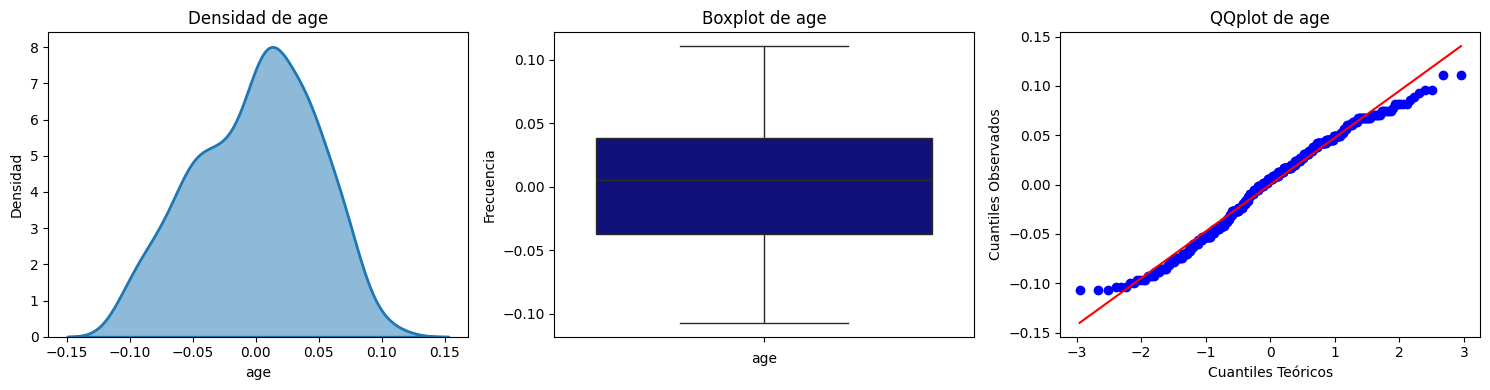

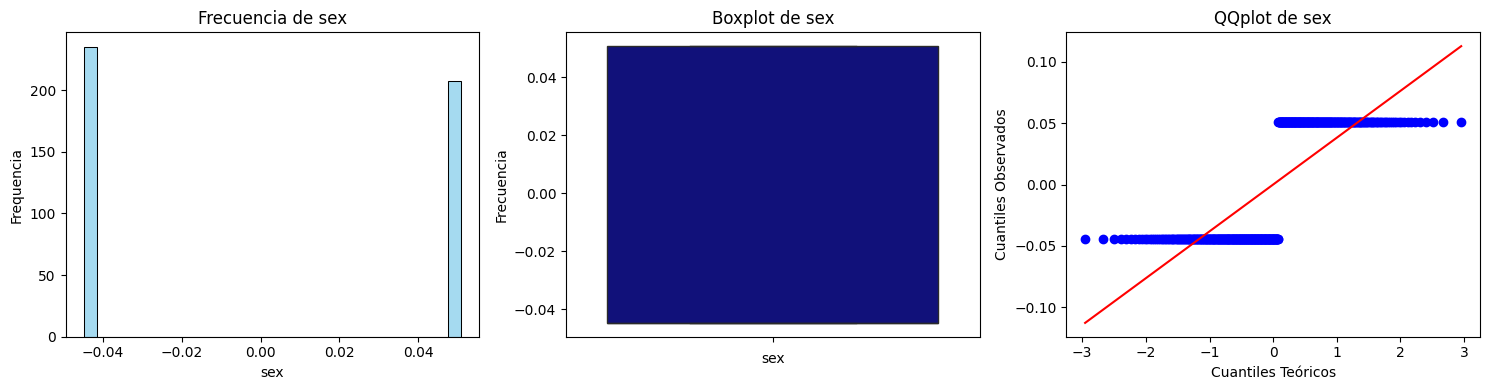

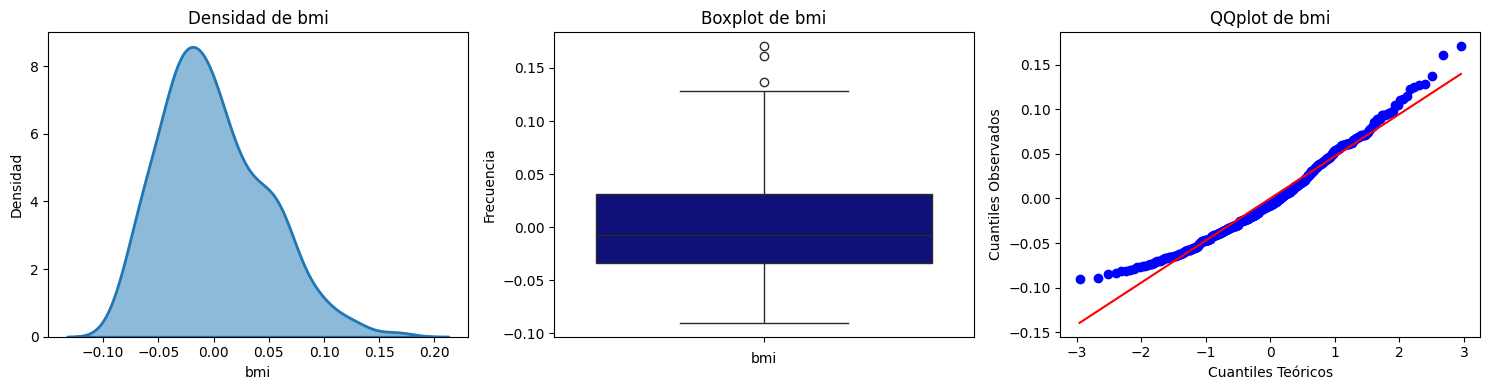

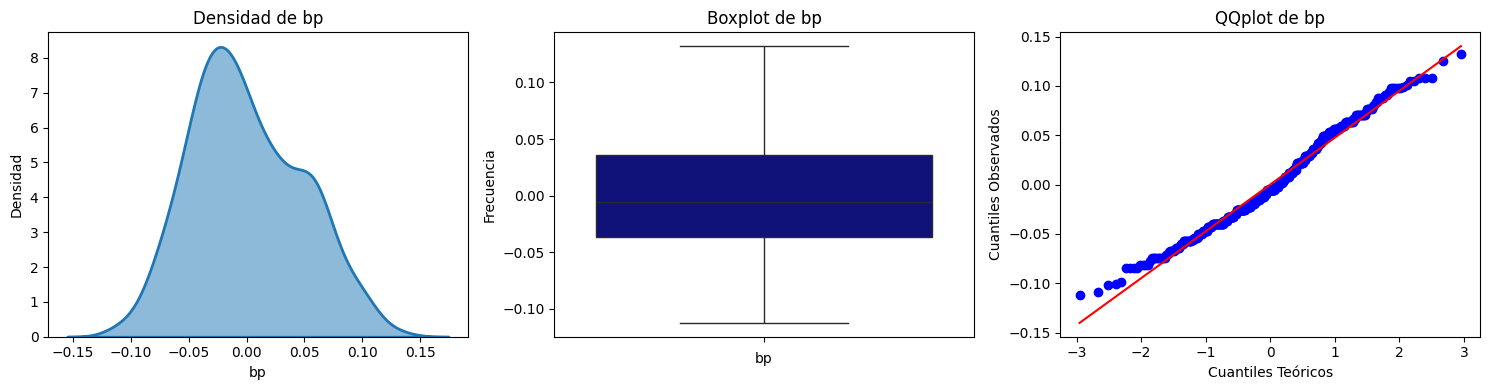

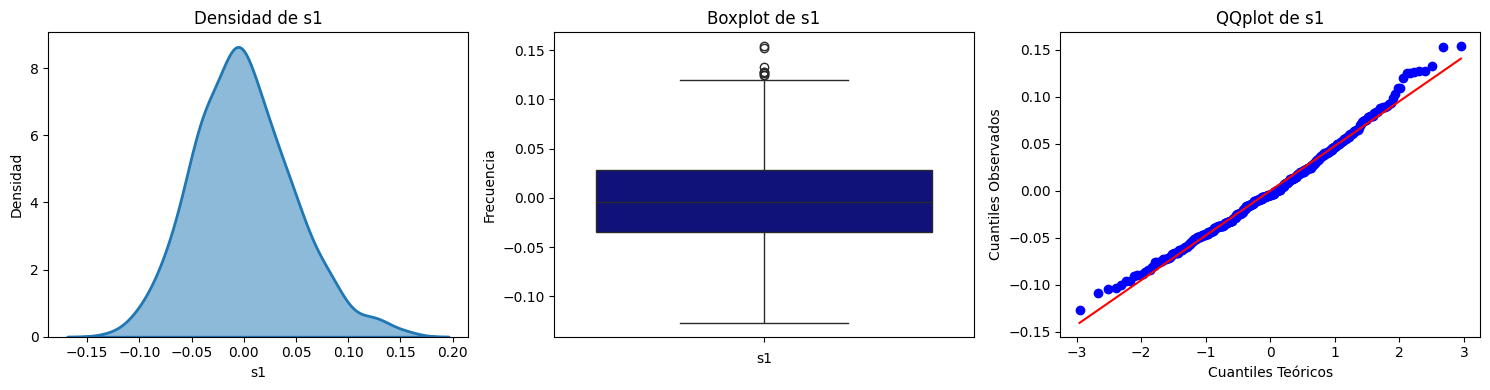

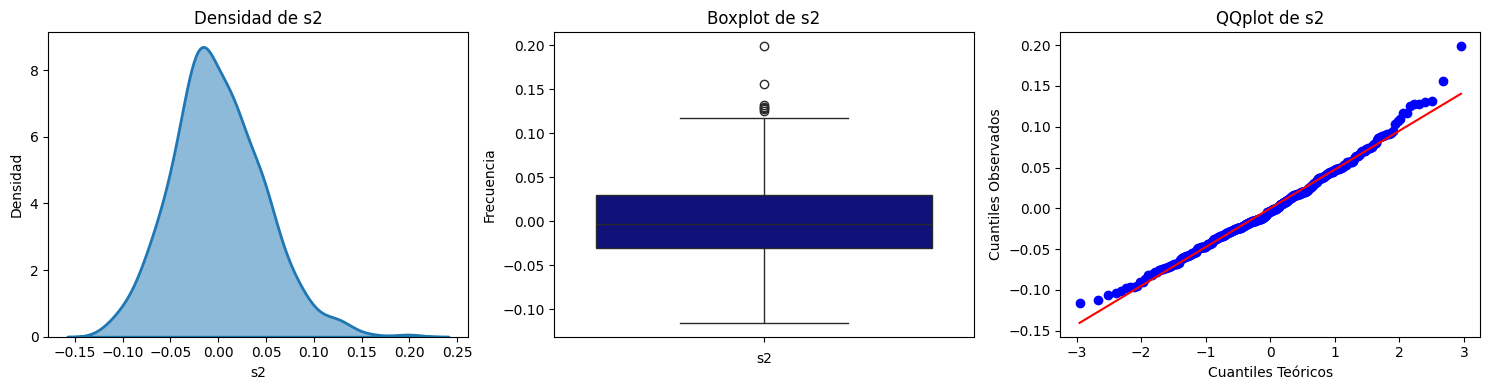

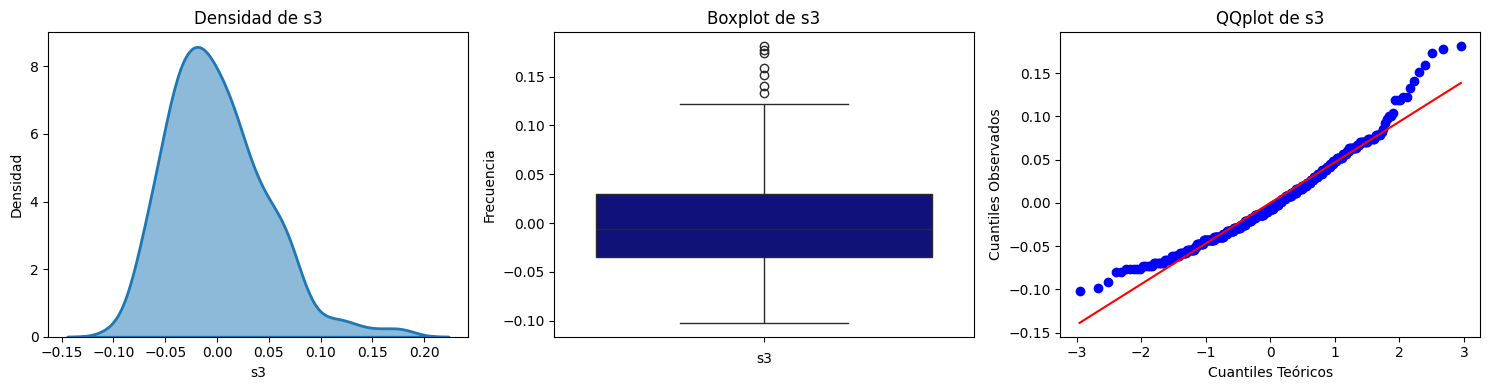

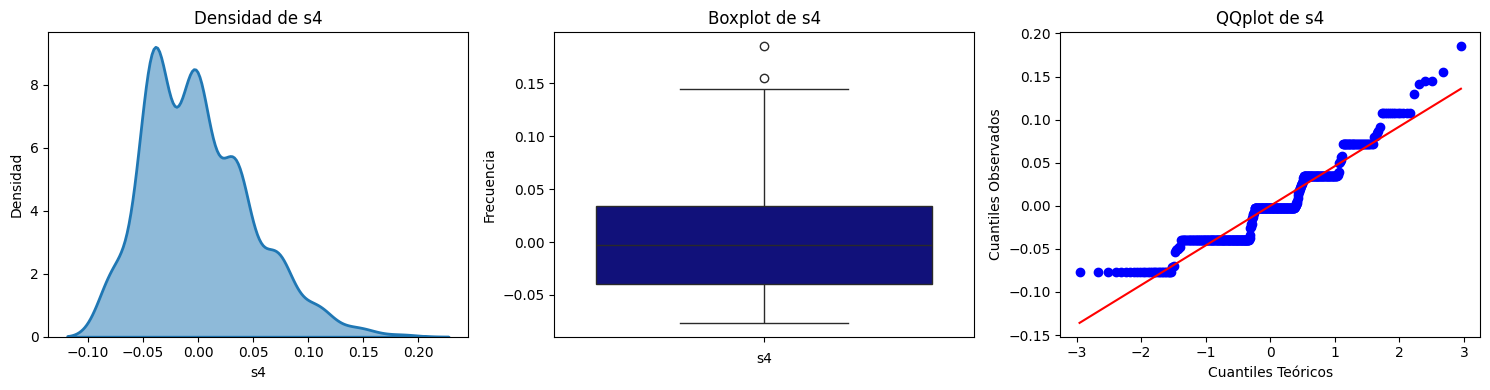

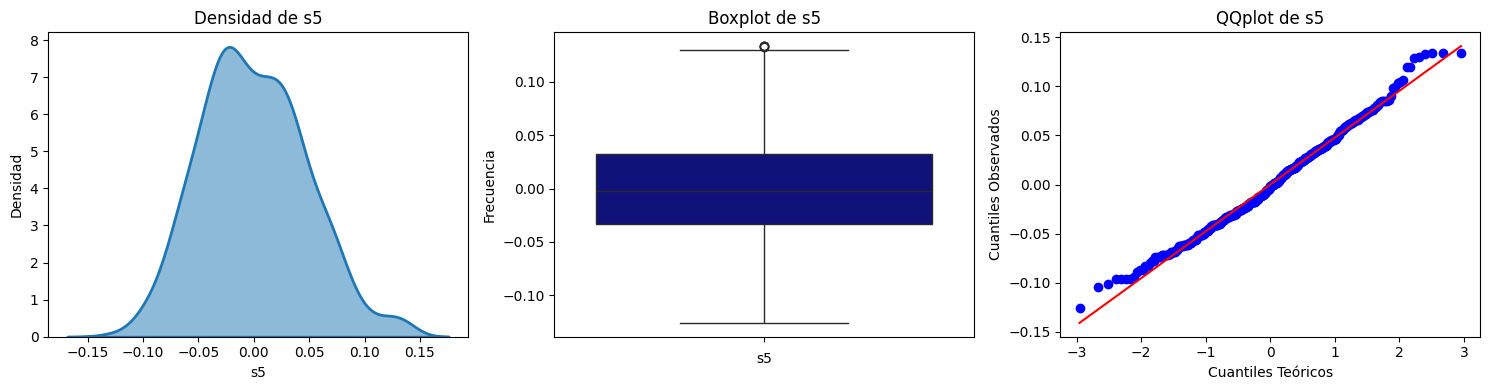

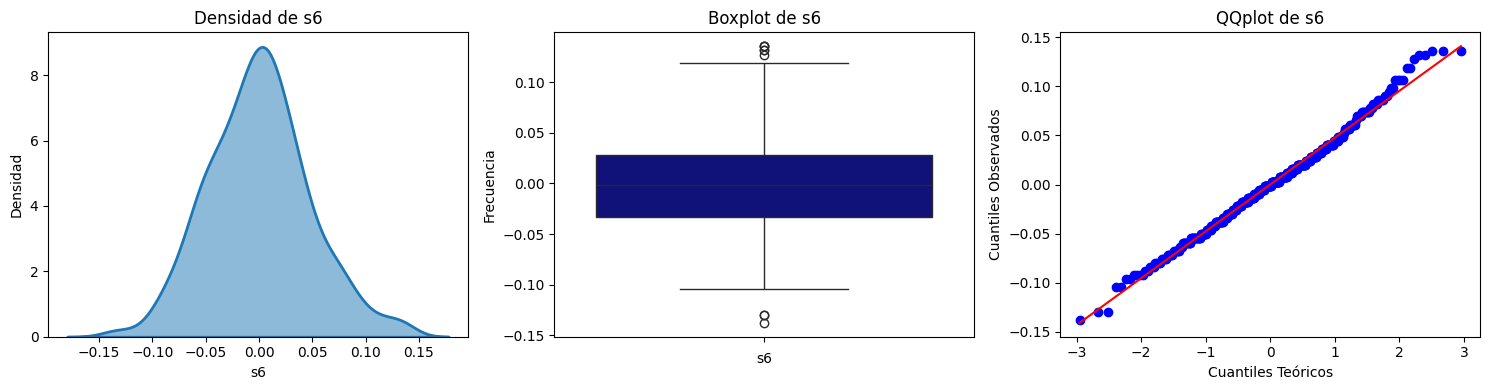

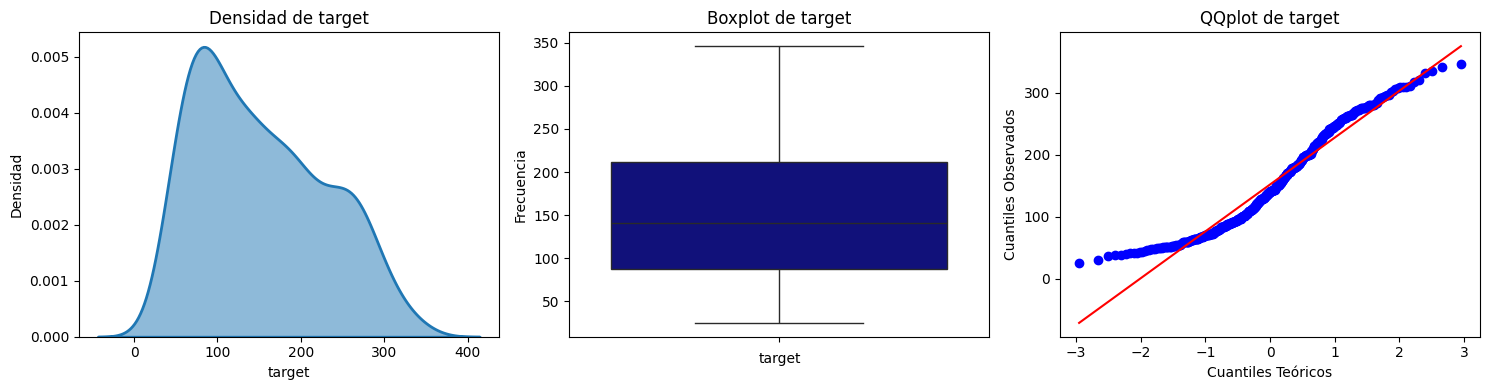

In [60]:
for col in df_diabetes.columns:  # type: ignore

    plt.figure(figsize=(15, 4))

    if len(df_diabetes[col].unique()) > 20:  # type: ignore
        plt.subplot(1, 3, 1)
        sns.kdeplot(data=df_diabetes, x=col, fill=True, alpha=0.5, linewidth=2)  # type: ignore
        plt.xlabel(col)
        plt.ylabel("Densidad")
        plt.title(f"Densidad de {col}")
    else:
        plt.subplot(1, 3, 1)
        sns.histplot(df_diabetes[col], bins=30, color="skyblue")  # type: ignore
        plt.xlabel(col)
        plt.ylabel("Frequencia")
        plt.title(f"Frecuencia de {col}")


    plt.subplot(1, 3, 2)
    sns.boxplot(data=df_diabetes[col], color="darkblue")  # type: ignore
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.title(f"Boxplot de {col}")

    plt.subplot(1, 3, 3)
    probplot(x=df_diabetes[col], dist="norm", plot=plt)  # type: ignore
    plt.xlabel("Cuantiles Teóricos")
    plt.ylabel("Cuantiles Observados")
    plt.title(f"QQplot de {col}")


    plt.tight_layout()

    plt.show()

#### 1 Utilizando  el  conjunto  de  datos  "Diabetes",  ¿cuál  es  la  progresión  de  la  enfermedad después de un año para un paciente de 45 años, con un índice de masa corporal (BMI) de 25 y una presión arterial media (BP) de 80? Utiliza un modelo de regresión lineal para hacer la predicción.

In [66]:
# Si no existe la columna 'progression', la añadimos desde el conjunto de datos
if 'progression' not in df_diabetes.columns:
    df_diabetes['progression'] = diabetes.target

# Seleccionar características relevantes y la etiqueta
features = df_diabetes[['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']]
target = df_diabetes['progression']

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Normalización de características relevantes basándonos en los datos del DataFrame
def normalize_feature(value, feature_name):
    mean_value = df_diabetes[feature_name].mean()
    std_value = df_diabetes[feature_name].std()
    return (value - mean_value) / std_value

# Normalizar los valores del paciente
normalized_age = normalize_feature(45, 'age')
normalized_bmi = normalize_feature(25, 'bmi')
normalized_bp = normalize_feature(80, 'bp')

# Suponemos valores promedio para las mediciones de suero sanguíneo S1 a S6
mean_s1 = df_diabetes['s1'].mean()
mean_s2 = df_diabetes['s2'].mean()
mean_s3 = df_diabetes['s3'].mean()
mean_s4 = df_diabetes['s4'].mean()
mean_s5 = df_diabetes['s5'].mean()
mean_s6 = df_diabetes['s6'].mean()

# Crear las características del paciente
patient_data = np.array([[normalized_age, 0, normalized_bmi, normalized_bp, mean_s1, mean_s2, mean_s3, mean_s4, mean_s5, mean_s6]])

# Hacer la predicción
initial_progression = 0  # Esto será nuestro punto de referencia
prediction = model.predict(patient_data)

print("Progresión inicial de la enfermedad (referencia):", initial_progression)
print("La progresión de la enfermedad después de un año es:", prediction[0])

# Evaluar el modelo usando las métricas de evaluación
y_pred = model.predict(X_test)

# Calcular las métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nMétricas de Evaluación del Modelo:")
print("Error Medio Absoluto (MAE):", mae)
print("Error Cuadrático Medio (MSE):", mse)
print("Raíz del Error Cuadrático Medio (RMSE):", rmse)
print("Coeficiente de Determinación (R²):", r2)


Progresión inicial de la enfermedad (referencia): 0
La progresión de la enfermedad después de un año es: 904888.2017766915

Métricas de Evaluación del Modelo:
Error Medio Absoluto (MAE): 42.794094679599944
Error Cuadrático Medio (MSE): 2900.193628493482
Raíz del Error Cuadrático Medio (RMSE): 53.85344583676593
Coeficiente de Determinación (R²): 0.4526027629719195


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


#### 2. Aplicando una regresión polinomial de grado 2 al conjunto de datos "Diabetes", ¿cuál es la progresión de la enfermedad después de un año para un paciente de 55 años con un índice de masa corporal (BMI) de 30 y una presión arterial media (BP) de 90?

In [67]:
from sklearn.preprocessing import PolynomialFeatures

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Transformar características en características polinomiales de grado 2
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Crear y entrenar el modelo de regresión lineal con características polinomiales
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Normalizar los valores del paciente
normalized_age = normalize_feature(55, 'age')
normalized_bmi = normalize_feature(30, 'bmi')
normalized_bp = normalize_feature(90, 'bp')

# Suponemos valores promedio para las mediciones de suero sanguíneo S1 a S6
mean_s1 = df_diabetes['s1'].mean()
mean_s2 = df_diabetes['s2'].mean()
mean_s3 = df_diabetes['s3'].mean()
mean_s4 = df_diabetes['s4'].mean()
mean_s5 = df_diabetes['s5'].mean()
mean_s6 = df_diabetes['s6'].mean()

# Crear las características del paciente y transformarlas en características polinomiales
patient_data = np.array([[normalized_age, 0, normalized_bmi, normalized_bp, mean_s1, mean_s2, mean_s3, mean_s4, mean_s5, mean_s6]])
patient_data_poly = poly.transform(patient_data)

# Hacer la predicción
prediction = model.predict(patient_data_poly)

print("La progresión de la enfermedad después de un año es:", prediction[0])

# Evaluar el modelo usando las métricas de evaluación
y_pred = model.predict(X_test_poly)

# Calcular las métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nMétricas de Evaluación del Modelo:")
print("Error Medio Absoluto (MAE):", mae)
print("Error Cuadrático Medio (MSE):", mse)
print("Raíz del Error Cuadrático Medio (RMSE):", rmse)
print("Coeficiente de Determinación (R²):", r2)

La progresión de la enfermedad después de un año es: 7083585325.550218

Métricas de Evaluación del Modelo:
Error Medio Absoluto (MAE): 43.58169325465219
Error Cuadrático Medio (MSE): 3096.0283073442615
Raíz del Error Cuadrático Medio (RMSE): 55.64196534401226
Coeficiente de Determinación (R²): 0.4156399336408021


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


#### 3. Utilizando un modelo de regresión logística, ¿qué probabilidad hay de que un paciente con diabetes sea de género femenino (Sex = 1) y tenga un índice de masa corporal (BMI) de 28? Elige  un  umbral  de  probabilidad  del  0.5  para  determinar  si  el  paciente  tiene  una  alta probabilidad de progresión de la enfermedad.

In [68]:
from sklearn.metrics import classification_report, accuracy_score

# Crear una columna binaria para indicar si la progresión es alta (> la mediana)
df_diabetes['high_progression'] = (df_diabetes['progression'] > df_diabetes['progression'].median()).astype(int)

# Seleccionar características relevantes y la etiqueta
features = df_diabetes[['sex', 'bmi']]
target = df_diabetes['high_progression']

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Normalizar los valores del paciente
normalized_bmi = normalize_feature(28, 'bmi')

# Crear las características del paciente (Sex = 1, BMI = 28)
patient_data = np.array([[1, normalized_bmi]])

# Realizar la predicción de probabilidad
probability = model.predict_proba(patient_data)[0, 1]

# Determinar si el paciente tiene una alta probabilidad de progresión de la enfermedad
threshold = 0.5
high_risk = probability > threshold

print("Probabilidad de que el paciente tenga una alta progresión de la enfermedad:", probability)
print("Alta probabilidad de progresión de la enfermedad (umbral 0.5):", high_risk)

# Evaluar el modelo usando las métricas de evaluación
y_pred = model.predict(X_test)

# Obtener las métricas de evaluación
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("\nMétricas de Evaluación del Modelo:")
print(report)
print("Precisión del modelo:", accuracy)

Probabilidad de que el paciente tenga una alta progresión de la enfermedad: 1.0
Alta probabilidad de progresión de la enfermedad (umbral 0.5): True

Métricas de Evaluación del Modelo:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        49
           1       0.68      0.68      0.68        40

    accuracy                           0.71        89
   macro avg       0.70      0.70      0.70        89
weighted avg       0.71      0.71      0.71        89

Precisión del modelo: 0.7078651685393258


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


#### 4. Aplicando  el  modelo  de  regresión  lasso  (L2)  al  conjunto  de  datos  "Diabetes",  ¿cuál  es  la progresión de la enfermedad después de un año para un paciente de 50 años con un índice de masa corporal (BMI) de 27 y una presión arterial media (BP) de 85? Utiliza un parámetro de regularización alpha = 0.5. 

In [70]:
# Seleccionar características relevantes y la etiqueta
features = df_diabetes[['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']]
target = df_diabetes['progression']

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión Lasso con alpha = 0.5
alpha_value = 0.5
model = Lasso(alpha=alpha_value)
model.fit(X_train, y_train)

# Normalizar los valores del paciente
normalized_age = normalize_feature(50, 'age')
normalized_bmi = normalize_feature(27, 'bmi')
normalized_bp = normalize_feature(85, 'bp')

# Suponemos valores promedio para las mediciones de suero sanguíneo S1 a S6
mean_s1 = df_diabetes['s1'].mean()
mean_s2 = df_diabetes['s2'].mean()
mean_s3 = df_diabetes['s3'].mean()
mean_s4 = df_diabetes['s4'].mean()
mean_s5 = df_diabetes['s5'].mean()
mean_s6 = df_diabetes['s6'].mean()

# Crear las características del paciente
patient_data = np.array([[normalized_age, 0, normalized_bmi, normalized_bp, mean_s1, mean_s2, mean_s3, mean_s4, mean_s5, mean_s6]])

# Hacer la predicción
prediction = model.predict(patient_data)

print("La progresión de la enfermedad después de un año es:", prediction[0])

# Evaluar el modelo usando las métricas de evaluación
y_pred = model.predict(X_test)

# Calcular las métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nMétricas de Evaluación del Modelo:")
print("Error Medio Absoluto (MAE):", mae)
print("Error Cuadrático Medio (MSE):", mse)
print("Raíz del Error Cuadrático Medio (RMSE):", rmse)
print("Coeficiente de Determinación (R²):", r2)

La progresión de la enfermedad después de un año es: 586769.3911971432

Métricas de Evaluación del Modelo:
Error Medio Absoluto (MAE): 44.91515452534397
Error Cuadrático Medio (MSE): 2945.148879042492
Raíz del Error Cuadrático Medio (RMSE): 54.26922589315691
Coeficiente de Determinación (R²): 0.44411768125231843


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
